In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm

pd.set_option('max_rows', 20)



# Financial Sector - Estimation

All data series were downloaded from the [World Bank Website](http://data.worldbank.org)

* Financial Depth: Domestic credit provided by financial sector (% of GDP) - EXPLANATORY VARIABLE
* Real GDP Per Capita: GDP per capita, PPP (current international $) - RESPONSE VARIABLE
* Inflation Rate Inflation, consumer prices (annual %) - CONTROL VARIABLE
* Merchandise Trade: Merchandise trade (% of GDP) - CONTROL VARIABLE
* Primary completion rate, total (% of relevant age group) - We opted for this as a education proxy - CONTROL VARIABLE


## Load

In [2]:
df = pd.read_excel('Data.xlsx',None)

In [3]:
def sortDf(df,key):
    df.drop(['Country Name','Indicator Code','Indicator Name',], axis=1, inplace=True)
    df = pd.DataFrame(df.set_index('Country Code').stack())
    df.columns = [key]
    return df

In [4]:
dfsList = []
for key in df.keys():
    dfsList.append(sortDf(df[key],key))

In [5]:
df = pd.concat(dfsList,axis=1)
df

Pop  FinancDepth  InflationRate  \
Country Code                                                
ABW          1960     54208.0          NaN            NaN   
             1961     55435.0          NaN            NaN   
             1962     56226.0          NaN            NaN   
             1963     56697.0          NaN            NaN   
             1964     57029.0          NaN            NaN   
             1965     57360.0          NaN            NaN   
             1966     57712.0          NaN            NaN   
             1967     58049.0          NaN            NaN   
             1968     58385.0          NaN            NaN   
             1969     58724.0          NaN            NaN   
...                       ...          ...            ...   
ZWE          2006  13127942.0          NaN    1096.677633   
             2007  13297798.0          NaN   24411.030809   
             2008  13495462.0          NaN            NaN   
             2009  13720997.0          NaN            NaN   
             2010  13973897.0          NaN       3.034479   
             2011  14255592.0          NaN       3.277509   
             2012  14565482.0          NaN       3.922235   
             2013  14898092.0          NaN       1.631622   
             2014  15245855.0          NaN      -0.217286   
             2015  15602751.0          NaN      -2.398710   

                   PrimaryRateCompletion  MerchanTrade  GrossCapital  \
Country Code                                                           
ABW          1960                    NaN           NaN           NaN   
             1961                    NaN           NaN           NaN   
             1962                    NaN           NaN           NaN   
             1963                    NaN           NaN           NaN   
             1964                    NaN           NaN           NaN   
             1965                    NaN           NaN           NaN   
             1966                    NaN           NaN           NaN   
             1967                    NaN           NaN           NaN   
             1968                    NaN           NaN           NaN   
             1969                    NaN           NaN           NaN   
...                                  ...           ...           ...   
ZWE          2006                    NaN     78.987541      1.571161   
             2007                    NaN     93.538297      7.109753   
             2008                    NaN    116.629226      5.127906   
             2009                    NaN     63.367034     15.104423   
             2010                    NaN     74.284772     23.979764   
             2011                    NaN     72.215785     22.392920   
             2012              89.225418     66.833044     13.612891   
             2013              90.249062     57.873718     13.033016   
             2014                    NaN     51.164230     13.236799   
             2015                    NaN     48.338968     13.239581   

                   RealGdpPerCapita  
Country Code                         
ABW          1960               NaN  
             1961               NaN  
             1962               NaN  
             1963               NaN  
             1964               NaN  
             1965               NaN  
             1966               NaN  
             1967               NaN  
             1968               NaN  
             1969               NaN  
...                             ...  
ZWE          2006       1449.120124  
             2007       1415.027698  
             2008       1170.461903  
             2009       1229.382424  
             2010       1360.876026  
             2011       1523.621784  
             2012       1679.125594  
             2013       1743.210783  
             2014       1798.059812  
             2015       1793.586092  

[14628 rows x 7 columns]

# Selecting Our Sample

We will try to use a similar time window of 15 years, thus from 2000 to 2015

In [6]:
df = df.swaplevel()

listOfYears = []
for i in range(1999,2015):
    listOfYears.append(str(i))

df.sort_index(inplace=True)
idx = pd.IndexSlice
df = df.loc[idx[listOfYears,:],:]

Now we have to find countries with complete data

In [7]:
df = df.swaplevel().sort_index()
df.index.names=["Country Code","Year"]
df

Pop  FinancDepth  InflationRate  \
Country Code Year                                           
ABW          1999     89004.0    44.554334       2.280372   
             2000     90858.0    44.102276       4.044021   
             2001     92894.0    44.822054       2.883604   
             2002     94995.0    49.103685       3.315775   
             2003     97015.0    54.435883       3.657377   
             2004     98742.0    51.686147       2.529938   
             2005    100031.0    54.159209       3.395625   
             2006    100830.0    53.381129       3.608711   
             2007    101218.0    51.376289       5.391203   
             2008    101342.0    47.309394       8.957732   
...                       ...          ...            ...   
ZWE          2005  12984418.0    55.330227     302.116996   
             2006  13127942.0          NaN    1096.677633   
             2007  13297798.0          NaN   24411.030809   
             2008  13495462.0          NaN            NaN   
             2009  13720997.0          NaN            NaN   
             2010  13973897.0          NaN       3.034479   
             2011  14255592.0          NaN       3.277509   
             2012  14565482.0          NaN       3.922235   
             2013  14898092.0          NaN       1.631622   
             2014  15245855.0          NaN      -0.217286   

                   PrimaryRateCompletion  MerchanTrade  GrossCapital  \
Country Code Year                                                      
ABW          1999             101.619118    196.364238     27.723498   
             2000              97.215950    272.496034     25.494114   
             2001              94.335510    249.698162     23.701659   
             2002              94.755241    180.566748     26.914487   
             2003              90.155090    220.119233     29.207629   
             2004              90.559898    315.211778     28.790409   
             2005              88.197968    373.397244     33.573158   
             2006              93.127357    389.796606     35.207778   
             2007              95.588242    393.812800     32.399015   
             2008              95.133034    410.724326     32.690226   
...                                  ...           ...           ...   
ZWE          2005                    NaN     72.977288      1.525177   
             2006                    NaN     78.987541      1.571161   
             2007                    NaN     93.538297      7.109753   
             2008                    NaN    116.629226      5.127906   
             2009                    NaN     63.367034     15.104423   
             2010                    NaN     74.284772     23.979764   
             2011                    NaN     72.215785     22.392920   
             2012              89.225418     66.833044     13.612891   
             2013              90.249062     57.873718     13.033016   
             2014                    NaN     51.164230     13.236799   

                   RealGdpPerCapita  
Country Code Year                    
ABW          1999               NaN  
             2000               NaN  
             2001               NaN  
             2002               NaN  
             2003               NaN  
             2004               NaN  
             2005               NaN  
             2006               NaN  
             2007               NaN  
             2008               NaN  
...                             ...  
ZWE          2005       1472.435072  
             2006       1449.120124  
             2007       1415.027698  
             2008       1170.461903  
             2009       1229.382424  
             2010       1360.876026  
             2011       1523.621784  
             2012       1679.125594  
             2013       1743.210783  
             2014       1798.059812  

[4207 rows x 7 columns]

In [8]:
# Check not null countries
# pd.set_option('max_rows', 500)
# ~(df.isnull().groupby(level="Country Code").any().any(axis=1))

In [9]:
penn_table = pd.read_stata("pwt90_labor_detail.dta")

In [10]:
penn_table["year"] = penn_table["year"].astype(int)
penn_table["year"] = penn_table["year"].astype(str)
penn_table.set_index(["countrycode","year"],inplace=True)
penn_table.index.names = ["Country Code","Year"]
penn_table = penn_table[["yr_sch"]]

In [11]:
penn_table.head()

yr_sch
Country Code Year        
ABW          1950     NaN
             1951     NaN
             1952     NaN
             1953     NaN
             1954     NaN

In [12]:
df = pd.concat([df, penn_table], axis=1)
df

Pop  FinancDepth  InflationRate  \
Country Code Year                                           
ABW          1950         NaN          NaN            NaN   
             1951         NaN          NaN            NaN   
             1952         NaN          NaN            NaN   
             1953         NaN          NaN            NaN   
             1954         NaN          NaN            NaN   
             1955         NaN          NaN            NaN   
             1956         NaN          NaN            NaN   
             1957         NaN          NaN            NaN   
             1958         NaN          NaN            NaN   
             1959         NaN          NaN            NaN   
...                       ...          ...            ...   
ZWE          2005  12984418.0    55.330227     302.116996   
             2006  13127942.0          NaN    1096.677633   
             2007  13297798.0          NaN   24411.030809   
             2008  13495462.0          NaN            NaN   
             2009  13720997.0          NaN            NaN   
             2010  13973897.0          NaN       3.034479   
             2011  14255592.0          NaN       3.277509   
             2012  14565482.0          NaN       3.922235   
             2013  14898092.0          NaN       1.631622   
             2014  15245855.0          NaN      -0.217286   

                   PrimaryRateCompletion  MerchanTrade  GrossCapital  \
Country Code Year                                                      
ABW          1950                    NaN           NaN           NaN   
             1951                    NaN           NaN           NaN   
             1952                    NaN           NaN           NaN   
             1953                    NaN           NaN           NaN   
             1954                    NaN           NaN           NaN   
             1955                    NaN           NaN           NaN   
             1956                    NaN           NaN           NaN   
             1957                    NaN           NaN           NaN   
             1958                    NaN           NaN           NaN   
             1959                    NaN           NaN           NaN   
...                                  ...           ...           ...   
ZWE          2005                    NaN     72.977288      1.525177   
             2006                    NaN     78.987541      1.571161   
             2007                    NaN     93.538297      7.109753   
             2008                    NaN    116.629226      5.127906   
             2009                    NaN     63.367034     15.104423   
             2010                    NaN     74.284772     23.979764   
             2011                    NaN     72.215785     22.392920   
             2012              89.225418     66.833044     13.612891   
             2013              90.249062     57.873718     13.033016   
             2014                    NaN     51.164230     13.236799   

                   RealGdpPerCapita    yr_sch  
Country Code Year                              
ABW          1950               NaN       NaN  
             1951               NaN       NaN  
             1952               NaN       NaN  
             1953               NaN       NaN  
             1954               NaN       NaN  
             1955               NaN       NaN  
             1956               NaN       NaN  
             1957               NaN       NaN  
             1958               NaN       NaN  
             1959               NaN       NaN  
...                             ...       ...  
ZWE          2005       1472.435072  6.753891  
             2006       1449.120124  6.852594  
             2007       1415.027698  6.951298  
             2008       1170.461903  7.050003  
             2009       1229.382424  7.148706  
             2010       1360.876026  7.247410  
             2011       1523.621784  7.426138  
     

In [13]:
# reselect sample
df = df.swaplevel().sort_index()
df = df.loc[idx[listOfYears,:],:]
df = df.swaplevel().sort_index()

In [14]:
df.loc["USA"]

,Pop,FinancDepth,InflationRate,PrimaryRateCompletion,MerchanTrade,GrossCapital,RealGdpPerCapita,yr_sch
Year,,,,,,,,
1999,279040000.0,201.263956,2.188027,NaN,18.168982,23.317953,34620.928899,12.879101
2000,282162411.0,190.962275,3.376857,NaN,19.846980,23.568925,36449.855116,12.925982
2001,284968955.0,198.587775,2.826171,NaN,17.965653,22.051491,37273.618103,12.966014
2002,287625193.0,191.785229,1.586032,NaN,17.247375,21.576522,38166.037841,13.006045
2003,290107933.0,206.579807,2.270095,NaN,17.616881,21.659967,39677.198348,13.046076
2004,292805298.0,212.918016,2.677237,NaN,19.067770,22.526727,41921.809762,13.086107
2005,295516599.0,216.329179,3.392747,NaN,20.114886,23.222953,44307.920585,13.126139
2006,298379912.0,226.324174,3.225944,NaN,21.247602,23.333015,46437.067117,13.185637
2007,301231207.0,235.894430,2.852672,NaN,21.886185,22.351353,48061.537661,13.245133


It appears that Primary Rate completion is not filled for many countries. Thus we will drop it for now.

In [15]:
df.drop('PrimaryRateCompletion',axis=1,inplace=True)

In [16]:
sampleCountries = ~(df.isnull().groupby(level="Country Code").any().any(axis=1))
# sampleCountries = ~(df.isnull().groupby(level="Year").any().any(axis=1))

In [17]:
sampleCountries = sampleCountries[sampleCountries==True].index
len(sampleCountries)

99

We have 101 countries in the sample. Which is more than the original paper with 77. We have our samples.

In [18]:
df = df.loc[list(sampleCountries)]

# Data Manipulations

## Calculate GDP Growth Rate

Since we only have the absolute value of the variable

In [19]:
df['GdpRate'] = df['RealGdpPerCapita'].groupby(level="Country Code").shift(0) / df['RealGdpPerCapita'].groupby(level="Country Code").shift(1)

## Years of Schooling

In [20]:

# Estava assim(no 1o):
# df['logYears'] = df['yr_sch'].groupby(level="Country Code").shift(0).apply(np.log) / df['yr_sch'].groupby(level="Country Code").shift(1).apply(np.log)
# df['logYears'] = df['yr_sch'].groupby(level="Country Code").shift(0) / df['yr_sch'].groupby(level="Country Code").shift(1)

df['logYears'] = df['yr_sch'].groupby(level="Country Code").shift(0).apply(np.log) - df['yr_sch'].groupby(level="Country Code").shift(1).apply(np.log)

## Ln() of Inflation

In [21]:
# df['LnInflation'] = np.log(df['InflationRate'] /  100)


In [22]:
df.head()

Pop  FinancDepth  InflationRate  MerchanTrade  \
Country Code Year                                                         
AGO          1999  14601983.0     7.219949     248.195902    134.342357   
             2000  15058638.0   -14.755435     324.996872    120.059565   
             2001  15562791.0    -0.319143     152.561022    108.694391   
             2002  16109696.0     5.004125     108.897436     96.724531   
             2003  16691395.0     6.626453      98.223718    105.631501   

                   GrossCapital  RealGdpPerCapita    yr_sch   GdpRate  \
Country Code Year                                                       
AGO          1999     28.899574       2972.321938  1.842842       NaN   
             2000     12.755027       3036.559728  1.940360  1.021612   
             2001     13.450919       3131.995858  2.006500  1.031429   
             2002     37.296420       2858.897069  2.072640  0.912804   
             2003     38.228106       2961.964572  2.138780  1.036051   

                   logYears  
Country Code Year            
AGO          1999       NaN  
             2000  0.051564  
             2001  0.033518  
             2002  0.032431  
             2003  0.031412

# Estimation

In [23]:
finalSample = df.groupby(level='Country Code').mean()
finalSample.head()

,Pop,FinancDepth,InflationRate,MerchanTrade,GrossCapital,RealGdpPerCapita,yr_sch,GdpRate,logYears
Country Code,,,,,,,,,
AGO,1.905277e+07,8.926300,69.089027,96.857211,21.889211,4932.878141,2.350161,1.064896,0.026690
ALB,2.983299e+06,57.991485,2.499683,46.887103,33.531553,7361.343772,9.672414,1.077493,0.006779
ARM,3.012131e+06,20.015437,3.950498,54.790870,27.253736,5247.252912,10.836354,1.096365,0.001143
AUS,2.098180e+07,128.484025,2.875061,34.182116,27.007916,35303.415480,12.517950,1.040971,-0.000967
BDI,8.490334e+06,24.433855,10.026976,28.081374,18.511548,649.535324,1.766831,1.020711,0.033431


In [24]:
finalSample['LnPop'] = np.log(finalSample['Pop'])
finalSample['LnGdp'] = np.log(finalSample['RealGdpPerCapita'])
# finalSample['LnPop'] = finalSample['Pop'] / 100000
# finalSample['LnGdp'] = finalSample['Pop'] / 100000
lista = ['FinancDepth','RealGdpPerCapita','MerchanTrade','LnInflation']
lista = ['FinancDepth','RealGdpPerCapita','MerchanTrade','LnInflation','Pop']
# lista = ['FinancDepth','RealGdpPerCapita','LnInflation','LnPop']
lista = ['FinancDepth','LnGdp','LnInflation','LnPop']
lista = ['FinancDepth','LnGdp','LnInflation','MerchanTrade',"yr_sch"]
lista = ['FinancDepth','MerchanTrade',"yr_sch","LnInflation",] # complete one

lista = ['FinancDepth','MerchanTrade',"LnInflation",]  # CHICKEN DINNER
# lista = ['FinancDepth','MerchanTrade',"LnInflation","LnPop"]  
lista = ['FinancDepth','MerchanTrade',"LnInflation","logYears"] 

# lista = ['FinancDepth','MerchanTrade',"InflationRate","logYears"] 

lista = ['FinancDepth'] 


In [25]:
finalSample[['GdpRate','FinancDepth','LnPop','InflationRate','MerchanTrade',"yr_sch"]].corr()

,GdpRate,FinancDepth,LnPop,InflationRate,MerchanTrade,yr_sch
GdpRate,1.000000,-0.178524,0.194827,0.187694,0.116703,0.160968
FinancDepth,-0.178524,1.000000,0.136277,-0.284931,0.069162,0.515680
LnPop,0.194827,0.136277,1.000000,0.137319,-0.284106,-0.144286
InflationRate,0.187694,-0.284931,0.137319,1.000000,-0.058638,-0.239741
MerchanTrade,0.116703,0.069162,-0.284106,-0.058638,1.000000,0.270071
yr_sch,0.160968,0.515680,-0.144286,-0.239741,0.270071,1.000000


In [26]:
finalSample = finalSample[finalSample["GdpRate"]<1.08]
finalSample = finalSample[finalSample["FinancDepth"]<150]

In [27]:
finalSample.shape

(81, 11)

In [28]:
samp = sm.add_constant(finalSample[lista])
# samp = finalSample[lista]

## Q=0.1

In [29]:
model = QuantReg(finalSample['GdpRate'], samp)
fitted = model.fit(q=0.1)
print(fitted.summary())

                         QuantReg Regression Results                          
Dep. Variable:                GdpRate   Pseudo R-squared:              0.04417
Model:                       QuantReg   Bandwidth:                     0.01852
Method:                 Least Squares   Sparsity:                      0.09975
Date:                Wed, 21 Jun 2017   No. Observations:                   81
Time:                        14:56:11   Df Residuals:                       79
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0180      0.006    170.061      0.000       1.006       1.030
FinancDepth     0.0001      0.000      1.131      0.261   -8.67e-05       0.000


## Q=0.25

In [30]:
model = QuantReg(finalSample['GdpRate'], samp)
fitted = model.fit(q=0.25)
print(fitted.summary())

                         QuantReg Regression Results                          
Dep. Variable:                GdpRate   Pseudo R-squared:              0.02166
Model:                       QuantReg   Bandwidth:                     0.01749
Method:                 Least Squares   Sparsity:                      0.05825
Date:                Wed, 21 Jun 2017   No. Observations:                   81
Time:                        14:56:11   Df Residuals:                       79
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0316      0.005    197.661      0.000       1.021       1.042
FinancDepth     0.0001   9.22e-05      1.127      0.263   -7.96e-05       0.000


## Q=0.5

In [31]:
model = QuantReg(finalSample['GdpRate'], samp)
fitted = model.fit(q=0.5)
print(fitted.summary())

                         QuantReg Regression Results                          
Dep. Variable:                GdpRate   Pseudo R-squared:             0.004669
Model:                       QuantReg   Bandwidth:                     0.01942
Method:                 Least Squares   Sparsity:                      0.04919
Date:                Wed, 21 Jun 2017   No. Observations:                   81
Time:                        14:56:11   Df Residuals:                       79
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0454      0.005    217.425      0.000       1.036       1.055
FinancDepth  6.031e-05   8.16e-05      0.739      0.462      -0.000       0.000


## Q=0.75

In [32]:
model = QuantReg(finalSample['GdpRate'], samp)
fitted = model.fit(q=0.75)
print(fitted.summary())

                         QuantReg Regression Results                          
Dep. Variable:                GdpRate   Pseudo R-squared:             0.008927
Model:                       QuantReg   Bandwidth:                     0.01749
Method:                 Least Squares   Sparsity:                      0.05485
Date:                Wed, 21 Jun 2017   No. Observations:                   81
Time:                        14:56:11   Df Residuals:                       79
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0625      0.004    238.885      0.000       1.054       1.071
FinancDepth -4.423e-05   7.37e-05     -0.600      0.550      -0.000       0.000


## Q=0.9

In [33]:
model = QuantReg(finalSample['GdpRate'], samp)
fitted = model.fit(q=0.9)
print(fitted.summary())

                         QuantReg Regression Results                          
Dep. Variable:                GdpRate   Pseudo R-squared:             0.004098
Model:                       QuantReg   Bandwidth:                     0.01852
Method:                 Least Squares   Sparsity:                      0.07798
Date:                Wed, 21 Jun 2017   No. Observations:                   81
Time:                        14:56:11   Df Residuals:                       79
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0709      0.004    275.948      0.000       1.063       1.079
FinancDepth     -3e-05   5.79e-05     -0.518      0.606      -0.000    8.53e-05


# OLS

In [34]:
model = sm.OLS(finalSample['GdpRate'], samp)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                GdpRate   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.7068
Date:                Wed, 21 Jun 2017   Prob (F-statistic):              0.403
Time:                        14:56:11   Log-Likelihood:                 218.97
No. Observations:                  81   AIC:                            -433.9
Df Residuals:                      79   BIC:                            -429.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0457      0.003    325.960      

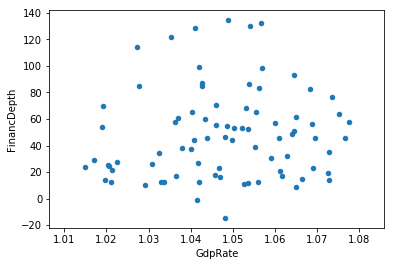

In [35]:
finalSample.plot.scatter("GdpRate","FinancDepth")


$$


$$

In [36]:
finalSample.to_excel('ListaPaises.xlsx')